<a href="https://colab.research.google.com/github/zsteve/wtf/blob/main/examples/trivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install colab_ssh on google colab
!pip install colab_ssh --upgrade
from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared
launch_ssh_cloudflared(password="grzoznlc")
# Optional: if you want to clone a github repository
init_git_cloudflared("https://github.com/zsteve/Tensor-project")

Enter your username: (leave it empty if it's 'None')
zsteve
Enter your password: 
··········


In [ ]:
# setup git
!git config --global user.email "syz@math.ubc.ca"
!git config --global user.name "Stephen Zhang"
!pip install tensorly
!pip install pot
!pip install gwot

     |████████████████████████████████| 112kB 8.2MB/s 
     |████████████████████████████████| 163kB 24.9MB/s 
  Created wheel for tensorly: filename=tensorly-0.5.1-cp37-none-any.whl size=149171 sha256=fbbaecaa79f71a637b63df586e9c66aa0c76a4bc40127673261d1101853f388d
  Stored in directory: /root/.cache/pip/wheels/88/1e/e7/b9677b2046cc87e17931b4b5781941786d3ee647825ca40ea6
Successfully built tensorly
     |████████████████████████████████| 440kB 8.0MB/s 


In [ ]:
!apt-get install vim
!git config --global credential.helper "cache --timeout=7200"

# cat to ~/.bashrc
# force_color_prompt=yes
# alias ls="ls --color=yes"
# alias tmux="TERM=xterm-256color tmux"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgpm2 vim-common vim-runtime xxd
Suggested packages:
  gpm ctags vim-doc vim-scripts
The following NEW packages will be installed:
  libgpm2 vim vim-common vim-runtime xxd
0 upgraded, 5 newly installed, 0 to remove and 51 not upgraded.
Need to get 6,722 kB of archives.
After this operation, 32.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xxd amd64 2:8.0.1453-1ubuntu1.4 [49.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 vim-common all 2:8.0.1453-1ubuntu1.4 [70.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgpm2 amd64 1.20.7-5 [15.1 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 vim-runtime all 2:8.0.1453-1ubuntu1.4 [5,435 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 vim amd64 2:8.0.1453

In [ ]:
PLT_CELL = 2.5
figs_path = "/content/Tensor-project/manuscript/figs/"

In [ ]:
import os
import sys
os.chdir("/content/Tensor-project")
sys.path.insert(0, "src")
import decomp

In [ ]:
import numpy as np
import copy
import tensorly as tl
from tensorly import tenalg, decomposition, cp_tensor
from tensorly.contrib.sparse import tensor as sptensor
import ot
import torch
import sklearn 
from sklearn import datasets
import matplotlib.pyplot as plt
tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tl_dtype = tl.float64

In [ ]:
import os
import sys
sys.path.insert(0, "src")
import decomp

In [ ]:
def gaussian(x, h):
    return np.exp(-(x/h)**2)

sizex, sizey = (16, 16)

x = np.linspace(-1, 1, 16)
mu_x = [0, -0.5, 0.5]
h_x = [0.25, 0.25, 0.25]
mu_y = [0, -0.5, 0.5]
h_y = [0.25, 0.25, 0.25]
mu_z = [0, -0.5, 0.5]
h_z = [0.25, 0.25, 0.25]

alpha = [decomp.normalise(gaussian(x - mu_x[i], h = h_x[i])) for i in range(len(mu_x))]
beta  = [decomp.normalise(gaussian(x - mu_y[i], h = h_y[i])) for i in range(len(mu_y))]
gamma = [decomp.normalise(gaussian(x - mu_z[i], h = h_z[i])) for i in range(len(mu_z))]

def outer_3(x, y, z):
    return np.einsum("i,j,k->ijk", x, y, z)

X = tl.tensor(sum([outer_3(alpha[i], beta[i], gamma[i]) for i in range(len(mu_x))]), dtype = tl_dtype)

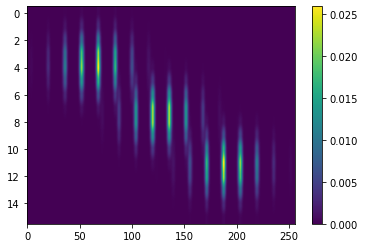

In [ ]:
plt.imshow(tl.unfold(X, 0))
plt.axis("auto")
plt.colorbar()

In [ ]:
xx, yy = np.meshgrid(range(sizex), range(sizey))
coords = np.vstack((xx.reshape(1, sizex*sizey), yy.reshape(1, sizex*sizey))).T
C_full = ot.utils.euclidean_distances(coords, coords, squared=True)
C_full = torch.Tensor(C_full/C_full.mean()).to(device)

C = ot.utils.euclidean_distances(x.reshape(-1, 1), x.reshape(-1, 1), squared = True)
C = torch.Tensor(C/C.mean()).to(device)

In [ ]:
import importlib
importlib.reload(decomp)

<module 'decomp' from 'src/decomp.py'>

In [ ]:
# now pick multilinear rank
d = 3
r = [3, ]*3
S = tl.zeros(r).to(device)
for i in range(r[0]):
    S[i, i, i] = 1

# initialise using SVD
factor_cp = tl.decomposition.non_negative_parafac(X, rank = r[0], n_iter_max = 0, init = "svd", random_state = 0)
A = copy.deepcopy(factor_cp.factors)
A = [a.to(device) for a in A]
X0 = X.to(device) 

###

# good params
# n_iter = 10
# lr = np.ones(n_iter)*0.1
# lamda = np.array([np.ones(3), ]*n_iter)*10
# optim_modes = [0, ]
# rho = np.array([np.array([1, 1, 1]), ]*n_iter)*0.01
# eps = np.array([np.ones(3), ]*n_iter)*0.01
n_iter = 10
lr = np.ones(n_iter)*0.001
lamda = np.array([np.ones(3), ]*n_iter)*25
optim_modes = [0, 1, 2]
rho = np.array([np.array([1, 1, 1]), ]*n_iter)*0.01
eps = np.array([np.ones(3), ]*n_iter)*0.01

In [ ]:
max_iter, print_inter, check_iter, tol, unbal = (2500, 100, 100, 1e-2, True)
for i in range(n_iter):
    print("Block iteration ", i)
    print("Mode 0") 
    m0 = decomp.FactorsModel(X0, 0, [C, ]*3, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "fiber", U_init = None, C_full = None, device = device, unbal = unbal)
    decomp.solve(m0, lr = lr[i], mode = "adam", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    print(m0.U[0].max())
    A[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = decomp.FactorsModel(X0, 1, [C, ]*3, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "fiber", U_init = None, C_full = None, device = device, unbal = unbal)
    decomp.solve(m1, lr = lr[i], mode = "adam", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    print(m1.U[0].max())
    A[1] = m1.compute_primal_variable().detach()
    print("Mode 2") 
    m2 = decomp.FactorsModel(X0, 2, [C, ]*3, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "fiber", U_init = None, C_full = None, device = device, unbal = unbal)
    decomp.solve(m2, lr = lr[i], mode = "adam", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    print(m2.U[0].max())
    A[2] = m2.compute_primal_variable().detach()
    # print("Core tensor")
    # m = decomp.CoreModel(X0, None, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "fiber", C_full = C_full, device = device, unbal = unbal)
    # decomp.solve(m, lr = lr[i], mode = "adam", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    # S = m.compute_primal_variable().detach()


Block iteration  0
Mode 0
i = 0 	 dual = 0.592185
i = 100 	 dual = 0.418097
i = 200 	 dual = 0.165667
i = 300 	 dual = -0.124223
i = 400 	 dual = -0.435575
i = 500 	 dual = -0.757609
i = 600 	 dual = -1.090216
i = 700 	 dual = -1.430923
i = 800 	 dual = -1.776993
i = 900 	 dual = -2.130275
i = 1000 	 dual = -2.491275
i = 1100 	 dual = -2.855513
i = 1200 	 dual = -3.222395
i = 1300 	 dual = -3.594243
i = 1400 	 dual = -3.969935
i = 1500 	 dual = -4.346995
i = 1600 	 dual = -4.728723
i = 1700 	 dual = -5.115736
i = 1800 	 dual = -5.504295
i = 1900 	 dual = -5.898279
i = 2000 	 dual = -6.301464
i = 2100 	 dual = -6.712722
i = 2200 	 dual = -7.132329
i = 2300 	 dual = -7.560699
i = 2400 	 dual = -7.996820
tensor(1.2107, device='cuda:0', grad_fn=<MaxBackward1>)
Mode 1
i = 0 	 dual = 1.008585
i = 100 	 dual = 0.009333
i = 200 	 dual = -0.737548
i = 300 	 dual = -1.444348
i = 400 	 dual = -2.132158
i = 500 	 dual = -2.806952
i = 600 	 dual = -3.474419
i = 700 	 dual = -4.133783
i = 800 	 dual

KeyboardInterrupt: ignored

(-0.5, 8.5, 2.5, -0.5)

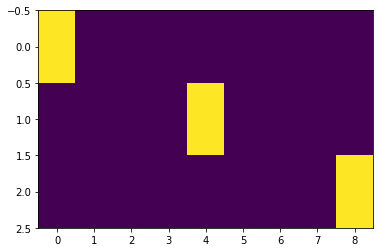

In [ ]:
plt.imshow(tl.unfold(S, 0).cpu())
plt.axis("auto")

In [ ]:
X_hat = tl.tenalg.multi_mode_dot(S, A).cpu()
factor_cp = tl.decomposition.non_negative_parafac(X, rank = r[0], init = "svd", n_iter_max = 500)
X_cp = tl.cp_tensor.cp_to_tensor(factor_cp)

(-0.5, 15.5, 255.5, -0.5)

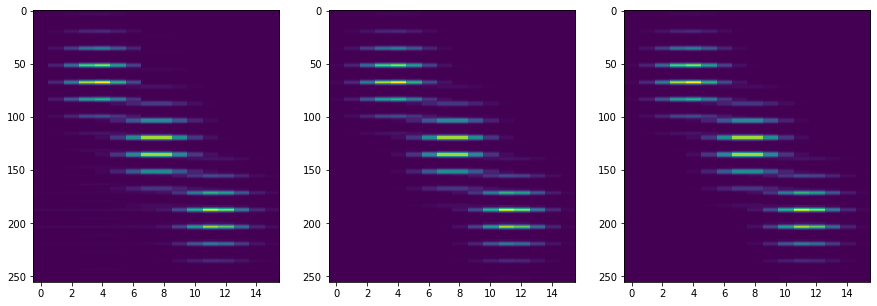

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_hat.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 3, 2)
plt.imshow(X_cp.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 3, 3)
plt.imshow(X.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")

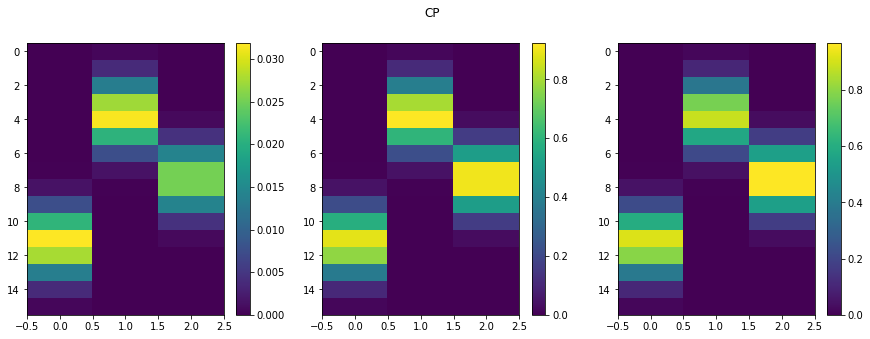

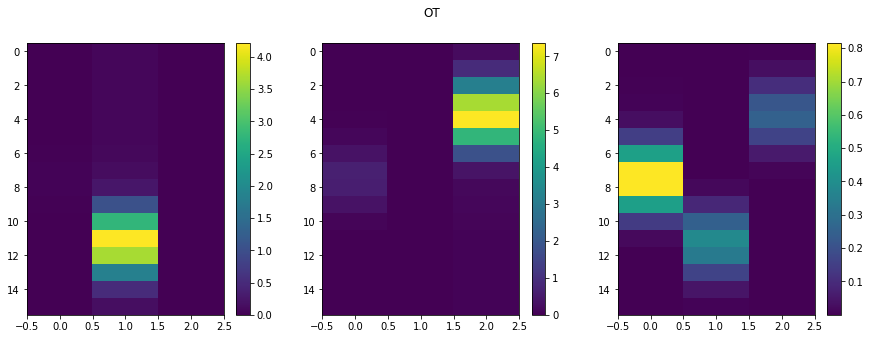

In [ ]:
plt.figure(figsize = (15, 5))
plt.suptitle("CP")
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(factor_cp.factors[i], interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

plt.figure(figsize = (15, 5))
plt.suptitle("OT")
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(A[i].cpu(), interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

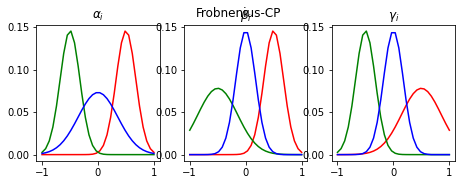

In [ ]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.suptitle("Frobnenius-CP")
plt.subplot(1, 3, 1)
plt.title("$\\alpha_i$")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(factor_cp.factors[0][:, 0]), color = "red")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(factor_cp.factors[0][:, 1]), color = "green")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(factor_cp.factors[0][:, 2]), color = "blue")
plt.subplot(1, 3, 2)
plt.title("$\\beta_i$")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(factor_cp.factors[1][:, 0]), color = "red")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(factor_cp.factors[1][:, 1]), color = "green")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(factor_cp.factors[1][:, 2]), color = "blue")
plt.subplot(1, 3, 3)
plt.title("$\\gamma_i$")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(factor_cp.factors[2][:, 0]), color = "red")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(factor_cp.factors[2][:, 1]), color = "green")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(factor_cp.factors[2][:, 2]), color = "blue")
plt.savefig(figs_path + "3mode_atoms_cp.pdf")

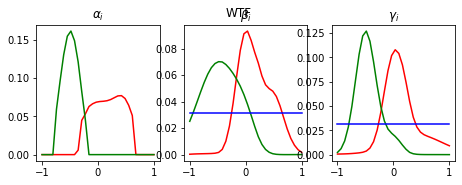

In [ ]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.subplot(1, 3, 1)
plt.suptitle("WTF")
plt.title("$\\alpha_i$")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(A[0][:, 0].cpu()), color = "red")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(A[0][:, 1].cpu()), color = "green")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(A[0][:, 2].cpu()), color = "blue")
plt.subplot(1, 3, 2)
plt.title("$\\beta_i$")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(A[1][:, 0].cpu()), color = "red")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(A[1][:, 1].cpu()), color = "green")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(A[1][:, 2].cpu()), color = "blue")
plt.subplot(1, 3, 3)
plt.title("$\\gamma_i$")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(A[2][:, 0].cpu()), color = "red")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(A[2][:, 1].cpu()), color = "green")
plt.plot(np.linspace(-1, 1, sizex), decomp.normalise(A[2][:, 2].cpu()), color = "blue")
plt.savefig(figs_path + "3mode_atoms_wtf.pdf")

NameError: ignored

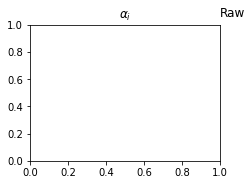

In [ ]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.suptitle("Raw")
plt.subplot(1, 2, 1)
plt.title("$\\alpha_i$")
for i in range(N):
    plt.plot(np.linspace(-1, 1, 32), decomp.normalise(factors1[i][0]), color = "red", alpha = 0.1)
    plt.plot(np.linspace(-1, 1, 32), decomp.normalise(factors2[i][0]), color = "green", alpha = 0.1)
    plt.plot(np.linspace(-1, 1, 32), decomp.normalise(factors3[i][0]), color = "blue", alpha = 0.1)
plt.subplot(1, 2, 2)
plt.title("$\\beta_i$")
for i in range(N):
    plt.plot(np.linspace(-1, 1, 32), decomp.normalise(factors1[i][1]), color = "red", alpha = 0.1)
    plt.plot(np.linspace(-1, 1, 32), decomp.normalise(factors2[i][1]), color = "green", alpha = 0.1)
    plt.plot(np.linspace(-1, 1, 32), decomp.normalise(factors3[i][1]), color = "blue", alpha = 0.1)
plt.savefig(figs_path + "3mode_atoms_raw.pdf")

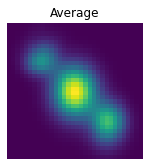

In [ ]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
plt.title("Average")
plt.imshow(X.sum(0))
plt.axis("off")
plt.savefig(figs_path + "3mode_avg.pdf")

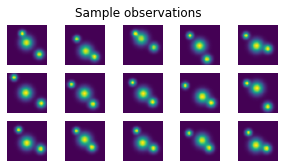

In [ ]:
plt.figure(figsize = (2*PLT_CELL, PLT_CELL))
plt.suptitle("Sample observations")
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.axis("off")
    plt.axis("auto")
    plt.imshow(X[i, :, :])
    plt.savefig(figs_path + "3mode_sample.pdf")

In [ ]:
d_ot = np.array([ot.emd2(decomp.normalise(X_hat[i, :, :].reshape(-1).double()), decomp.normalise(X[i, :, :].reshape(-1).double()), C_full.cpu()) for i in range(X.shape[0])])
d_baseline = np.array([ot.emd2(decomp.normalise(X_cp[i, :, :].reshape(-1).double()), decomp.normalise(X[i, :, :].reshape(-1).double()), C_full.cpu()) for i in range(X.shape[0])])

In [ ]:
d_ot.mean(), d_baseline.mean()

(0.014315779390661976, 0.02593169175081624)

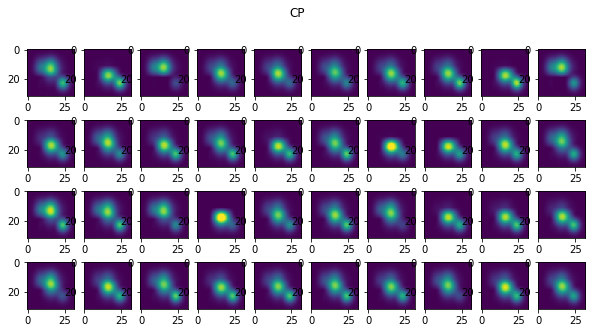

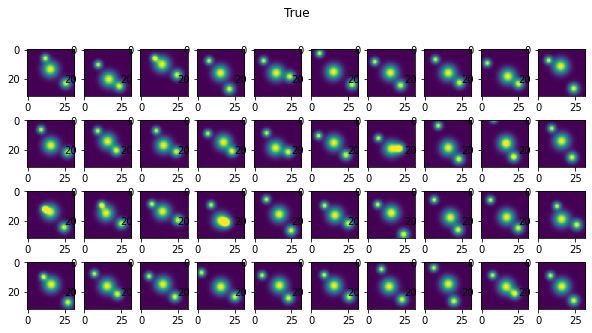

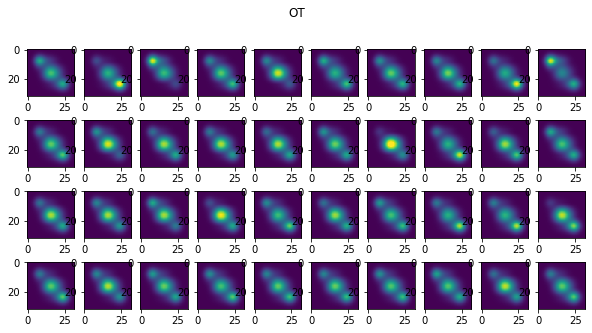

In [ ]:
vmax = np.quantile(X, 0.995)
plt.figure(figsize = (10, 5))
plt.suptitle("CP")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_cp[i, :].reshape(sizex, sizey), vmin = 0, vmax = vmax)

plt.figure(figsize = (10, 5))
plt.suptitle("True")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X[i, :].reshape(sizex, sizey), vmin = 0, vmax = vmax)

plt.figure(figsize = (10, 5))
plt.suptitle("OT")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_hat[i, :].reshape(sizex, sizey), vmin = 0, vmax = vmax)

In [ ]:
# now try NMF with the same dataset
from sklearn import decomposition
r_nmf = [3, ]*2
S_nmf = tl.zeros(r_nmf).to(device)
for i in range(r_nmf[0]):
    S_nmf[i, i] = 1

X0_nmf = tl.unfold(X, 0).to(device)
nmf_model = sklearn.decomposition.NMF(n_components = r_nmf[0], init = "nndsvd", max_iter = 1)
U_nmf = torch.Tensor(nmf_model.fit_transform(X0_nmf.cpu()))
V_nmf = torch.Tensor(nmf_model.components_)

A_nmf = copy.deepcopy([U_nmf, V_nmf.T])
A_nmf = [a.to(device) for a in A_nmf]

In [ ]:
params_nmf = {"n_iter" : 10}
params_nmf['lr'] = np.ones(params_nmf['n_iter'])*1
params_nmf['lamda'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*25
params_nmf['optim_modes'] = [0, ]
params_nmf['rho'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*0.01
params_nmf['eps'] = np.array([np.ones(2), ]*params_nmf['n_iter'])*0.01

In [ ]:
max_iter, print_inter, check_iter, unbal = (100, 10, 10, True)
tol = 1e-2
mode = "lbfgs"
for i in range(params_nmf['n_iter']):
    print("Block iteration ", i)
    print("Mode 0") 
    m0 = decomp.FactorsModel(X0_nmf, 0, None, S_nmf, A_nmf, params_nmf['rho'][i, :], params_nmf['eps'][i, :], params_nmf['lamda'][i, :], 
                             params_nmf['optim_modes'], ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
    decomp.solve(m0, lr = params_nmf['lr'][i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A_nmf[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = decomp.FactorsModel(X0_nmf, 1, None, S_nmf, A_nmf, params_nmf['rho'][i, :], params_nmf['eps'][i, :], params_nmf['lamda'][i, :], 
                             params_nmf['optim_modes'], ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
    decomp.solve(m1, lr = params_nmf['lr'][i], mode = mode, max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    A_nmf[1] = m1.compute_primal_variable().detach()


Block iteration  0
Mode 0
i = 0 	 dual = 8.144724
i = 10 	 dual = 7.779479
Mode 1


KeyboardInterrupt: ignored

In [ ]:
X_hat_nmf = tl.tenalg.multi_mode_dot(S_nmf, A_nmf ).cpu()
nmf_model = sklearn.decomposition.NMF(n_components = r_nmf[0], init = "nndsvd")
U_nmf = torch.Tensor(nmf_model.fit_transform(X0_nmf.cpu()))
V_nmf = torch.Tensor(nmf_model.components_)
X_nmf = U_nmf @ V_nmf

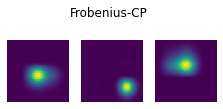

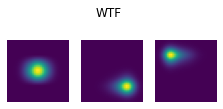

In [ ]:
plt.figure(figsize = (PLT_CELL*1.5, 0.75*PLT_CELL))
plt.suptitle("Frobenius-CP")
for i in range(r[0]):
    plt.subplot(1, r[0], i+1)
    plt.imshow(np.outer(factor_cp.factors[1][:, i], factor_cp.factors[2][:, i]))
    plt.axis("off")
plt.savefig(figs_path + "3mode_atoms2d_cp.pdf")
plt.figure(figsize = (PLT_CELL*1.5, 0.75*PLT_CELL))
plt.suptitle("WTF")
for i in range(r[0]):
    plt.subplot(1, r[0], i+1)
    plt.imshow(np.outer(A[1][:, i].cpu(), A[2][:, i].cpu()))
    plt.axis("off")
plt.savefig(figs_path + "3mode_atoms2d_wtf.pdf")

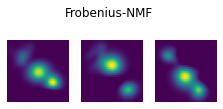

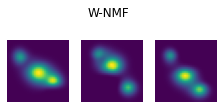

In [ ]:
plt.figure(figsize = (PLT_CELL*1.5, 0.75*PLT_CELL))
plt.suptitle("Frobenius-NMF")
for i in range(r[0]):
    plt.subplot(1, r[0], i+1)
    plt.imshow(V_nmf[i, :].reshape(sizex, sizey))
    plt.axis("off")
plt.savefig(figs_path + "3mode_atoms2d_nmf.pdf")

plt.figure(figsize = (PLT_CELL*1.5, 0.75*PLT_CELL))
plt.suptitle("W-NMF")
for i in range(r[0]):
    plt.subplot(1, r[0], i+1)
    plt.imshow(A_nmf[1][:, i].reshape(sizex, sizey).cpu())
    plt.axis("off")
plt.savefig(figs_path + "3mode_atoms2d_wnmf.pdf")